<a href="https://colab.research.google.com/github/apothula/dl/blob/main/Seg/03_FCN32s_Road_Custom_Metrics_and_Loss_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Semantic Segmentation using FCN-32s (KITTI Road Dataset)</h1>

<h2 style="font-size:24px;">Custom Accuracy Metrics and Loss Functions</h2>

In this notebook, we will continue using the KITTI Road dataset with the FCN-32s architecture. The emphasis will be on adding **custom accuracy metrics and loss functions** to the training processing pipeline.


<img src='https://opencv.org/wp-content/uploads/2022/07/c4-05-fcn-road-feature-image.png' align='center' width='1000'>

## Table of Contents

* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Modeling FCN32s with VGG-16 Backbone](#3-Modeling-FCN32s-with-VGG-16-Backbone)
* [4 Dataset Preparation](#4-Dataset-Preparation)
* [5 Custom Data Loader Class](#5-Custom-Data-Loader-Class)
* [6 Helper Functions and Utilities](#6-Helper-Functions-and-Utilities)
* [7 Using the Custom Data Loader Class](#7-Using-the-Custom-Data-Loader-Class)
* [8_Custom Accuracy Metrics](#8-Custom-Accuracy-Metrics)
* [9_Custom Loss Functions](#9-Custom-Loss-Functions)
* [10 Compile and Train the Model](#10-Compile-and-Train-the-Model)
* [11 Plot the Training Results](#11-Plot-the-Training-Results)
* [12 Perform Inference](#12-Perform-Inference)
* [13 Conclusion](#13-Conclusion)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile

from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Conv2DTranspose)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

## 1 System Configuration

In [ ]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 2
    IMG_WIDTH:   int = 224
    IMG_HEIGHT:  int = 224
    DATA_TRAIN_IMAGES: str = 'dataset_kitti_road_segmentation/train/images/*.png'
    DATA_TRAIN_LABELS: str = 'dataset_kitti_road_segmentation/train/masks/*.png'
    DATA_VALID_IMAGES: str = 'dataset_kitti_road_segmentation/valid/images/*.png'
    DATA_VALID_LABELS: str = 'dataset_kitti_road_segmentation/valid/masks/*.png'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 8
    EPOCHS:          int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = 'model_checkpoint/FCN_Road'

@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

## 3 Modeling FCN32s with VGG-16 Backbone
In the implementation below, we model FCN-32s with a VGG-16 backbone. In the original FCN-32s architecture, the authors replaced the two fully-connected layers of VGG-16 with two convolutional layers that transitioned from a 7x7 convolution to a 1x1 convolution (both with 4096 filters). Dropout layers were also added at each stage. These modified layers were then followed with a single 1x1 convolution with the number of filters set to the number of classes, followed by a transposed convolution with a stride of 32 to achieve the final segmentation map. To keep things simple and reduce the number of parameters in the model (thus, reducing the training time), we simply replaced the fully-connected layers in VGG-16 with a single 1x1 convolution with the number of filters set to the number of classes, followed by a transposed convolution with a stride of 32.

In [ ]:
def fcn32s_vgg16(num_classes, shape):

    model_input = Input(shape=shape)

    # Conv block 1.
    x = Conv2D(64, (3, 3), padding='same')(model_input)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 2.
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 3.
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 4.
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 5.
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # 1x1 convolution to limit the depth of the feature maps to the number of classes.
    x = Conv2D(num_classes, (1, 1), padding='same')(x)

    # Upsampling using Transposed Convolution.
    outputs = Conv2DTranspose(num_classes, kernel_size=(64, 64), strides=(32, 32),  padding='same')(x)

    model_output = Activation('softmax')(outputs)

    model = Model(inputs=model_input, outputs=model_output)

    return model

In [ ]:
model = fcn32s_vgg16(num_classes=DatasetConfig.NUM_CLASSES,
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                             

## 4 Dataset Preparation

### 4.1 Download and Extract the Dataset

This notebook will use the road segmentation images from the <a href="http://www.cvlibs.net/datasets/kitti/eval_road.php" target="_blank"> KITTI Road Evaluation dataset</a>. Although you can find the original dataset from the above link, we are providing a smaller version of the dataset to work with. The dataset that we will download further below has the following structure.

```
dataset_kitti_road_segmentation/

    ├── train
    │   ├── images [247 samples]
    │   └── masks  [247 samples]
    └── valid
        ├── images [42 samples]
        └── masks  [42 samples]
```

In [ ]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [ ]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
save_name = "dataset_kitti_road_segmentation.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/s/6vpsgn4gqtdiu01/dataset_kitti_road_segmentation.zip?dl=1",
        save_name
    )

    unzip(zip_file=save_name)

Extracted all


### 4.2 Mask Pre-Processing

There are a few important things to mention regarding the dataset:
* The ground truth segmentation masks have three colors (red, pink, and black). Red represents the background, pink represents the main road we wish to segment from the background, and black represents secondary roads/walkways other than the main road. We are only interested in the pink segmentation region as that consists of the main road in the original image.
* We, therefore, need to pre-process the segmentation masks in the dataset to create a binary mask consisting of just the main road and the background.
* The following sequence summarizes the processing steps that we will implement further below in the notebook. The main thing to note is that we create a single channel mask whose pixel values represent the class IDs.
* When we display the segmentation results, we can use a color map (dictionary) to map class IDs to colors. Since the original color map is harder to visualize, we decided to use a different color assignment for the two classes for visualization purposes (green for the main road and black for the background).
<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-mask-preprocessing.png" align='center' width=700>

## 5 Custom Data Loader Class

The next code block defines the custom data loader class that is based on the class we developed in the introductory notebook in this module. The only differnece is that this version uses a simplified verion of the `transforms()` method which only includes horizontal flipping.

In [ ]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(Sequence):

    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug):

        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug

        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

        if self.aug:
            self.train_transforms = self.transforms()

        self.resize_transforms = self.resize()

    def __len__(self):

        return len(self.mask_paths) // self.batch_size

    def transforms(self):

        # Data augmentation.
        train_transforms = A.Compose([A.HorizontalFlip(p=0.33),])
        return train_transforms

    def resize(self):

        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms

    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]

        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']

            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]

            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where
            # each channel represents a single class whose pixel values are either 0 or 1,
            # where a 1 represents a pixel location associated with the class that corresponds
            # to the channel.
            msk = rgb_to_onehot(msk)

            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)
            # representation whose values contain the class IDs for each class (essentially
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)

        return self.x, self.y

## 6 Helper Functions and Utilities

The color mapping dictionaries below define the maping between class IDs and RGB colors. The first dictionary defines the color mapping in the original dataset. It is used to map the RGB ground truth masks into a single channel representation that encodes the class IDs. The second color mapping is used to map class IDs to RGB values to render the predicted segmentation maps overlayed on the original image. The alternate color mapping is not required but was selected for visualization purposes only.

In [ ]:
id2color = {
    0: (255, 0, 0),   # Background: red
    1: (255, 0, 255), # Road: pink
}

id2color_display = {
    0: (0, 0, 0),     # Background: black
    1: (0, 255, 0),   # Road: green
}

When preparing the masks in the custom data loader class, we need to convert the RGB images to one-hot encoded images where the number of channels will be the same as the number of channels (classes) in the dataset. The following function performs this conversion.

In [ ]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):

    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr

We will also need to make use of the function below that will convert a single channel mask to an RGB representation for visualization purposes. Each class ID in the single-channel mask will be converted to a different color according to the `id2color` dictionary mapping.

In [ ]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[single_layer==k] = color_map[k]

    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

Helper function to overlay an RGB segmentation map on top of an RGB image.

In [ ]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return np.clip(image, 0.0, 1.0)

The convenience function below will display the original image, the ground truth mask, and the ground truth mask overlayed on the original image. Note that there is an optional argument that allows you to control if the ground truth mask is displayed as a grayscale image or a color image.

In [ ]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):

    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)

    data_list.append(overlayed_image)

    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')

    plt.show()

## 7 Using the Custom Data Loader Class

Here we define the `create_datasets()` function that will be used below to generate training and validation dataset objects for the KITTI Road dataset. Notice that the augmentation flag for the validation dataset is explicitly set to `False` since data augmentation should only be an option for the training dataset.

In [ ]:
def create_datasets(aug=False):

    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))

    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                  )

    return train_ds, valid_ds

Now we call the above function to create the dataset objects and notice that the augmentation flag is set to `True`, but is only applied to the training dataset in the function above.

In [ ]:
train_ds, valid_ds = create_datasets(aug=True)

### 7.1 Display Sample Training Images

In the code cell below, we loop over the first three images in the training dataset and display the original image, the associated ground truth mask, and the ground truth mask overlayed on the original image. The overlay helps us better visualize the segmented classes in the context of the original image.

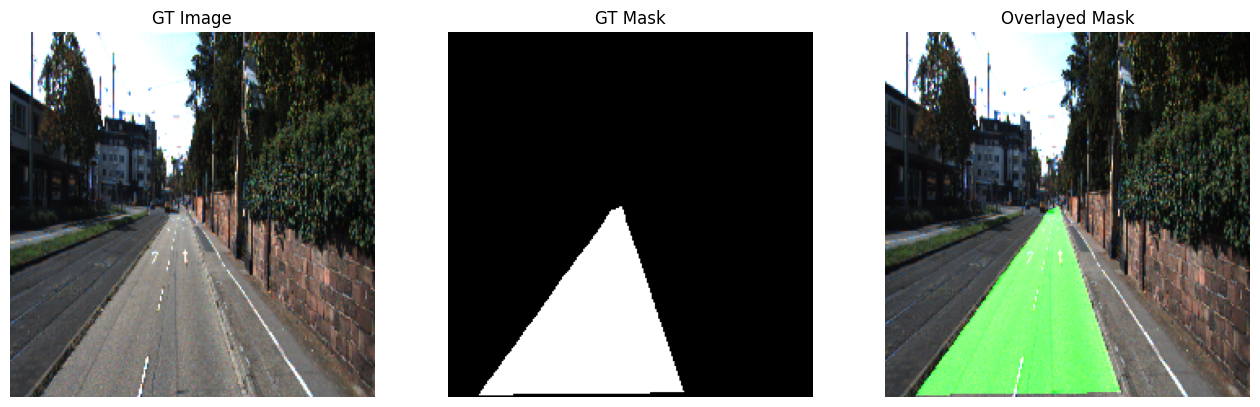

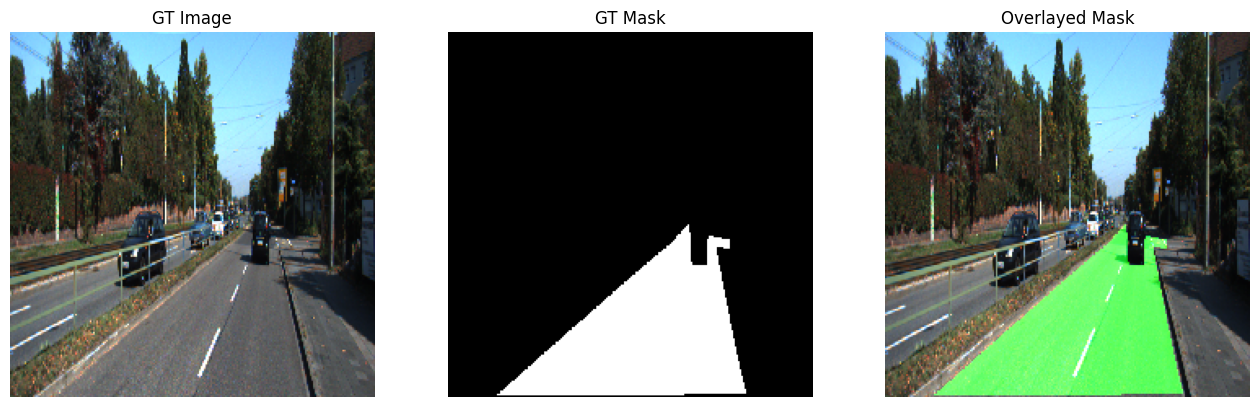

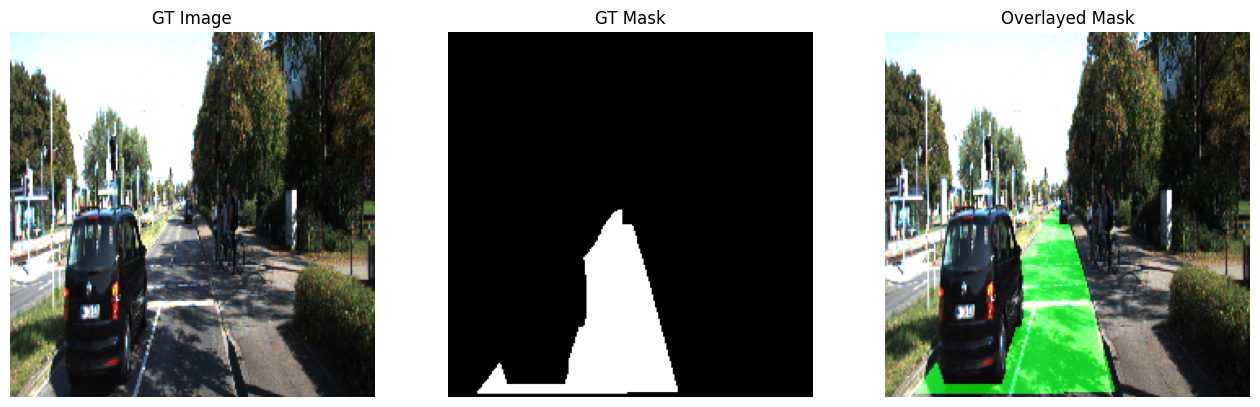

In [ ]:
for i, (images, masks) in enumerate(train_ds):
    if i == 3:
        break
    image, mask = images[0], masks[0]
    display_image_and_mask([image, mask], color_mask=False, color_map=id2color_display)

## 8 Custom Accuracy Metrics

In this section, we will review several accuracy metrics which can be used to assess segmentation results.

- Mean Pixel Accuracy
- Mean Intersection over Union (IoU): two approaches
- Dice Coefficient (otherwise also known as the F1-Score)

### 8.1 Mean Pixel Accuracy

When we train a model in Keras and specify `"accuracy"` as the metric, Keras will compute the mean pixel accuracy, which is the fraction of pixels correctly classified across all classes and images in a batch. We have already used accuracy in the context of image classification, and the interpretation is the same for semantic segmentation (except at the pixel level). In the function defined below, we compute the mean pixel accuracy and we will show further below how this is the same as using the built-in capability within Keras.

In [ ]:
def mean_pixel_accuracy(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                                Sparse respresentation of segmentation mask.

    y_pred (ndarray or tensor): Prediction (P) from the model with or without softmax.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Mean pixel accuracy metric.
    """

    # Get the dynamic shape of the prediction tensor
    shape = tf.shape(y_pred)

    # Get the total number of classes from the model output.
    num_classes = y_pred.shape[-1]

    # Calculate the number of pixels dynamically
    num_pixels = tf.cast(shape[1] * shape[2], tf.float32)

    # Convert single channel (sparse) ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Convert multi-channel predicted output to one-hot encoded thresholded output for metric computation.
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Axes for height, width and num_classes.
    axes = (1, 2, 3)

    # Intersection (number of correctly predicted pixels): |G ∩ P|. Shape: (batch_size,).
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Accuracy: (number correctly predicted) / num_pixels. Then mean across all batches.
    mean_acc = tf.math.reduce_mean(intersection / num_pixels, axis=0)

    return mean_acc

### 8.2 Mean IoU Metric (Naive)

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks `A` and `B`, the IoU is defined as follows:

$$
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU. However, there are two ways in which mean IoU can be computed. The first method below (`mean_iou_naive()`)  shows one approach. Notice that the computation for the mean IoU at the bottom of the function is performed across all the classes in the dataset regardless if they are contained in the ground truth mask or the predicted segmentation map. This approach can lead to an inflated metric computation when the number of classes is greater than two, and the ground truth mask and the predicted segmentation map contain a subset of the total number of classes. **We will not be using the computation below, but we wanted to mention it as something to be aware of because many repositories contain such implementations.** In the next section below, we use a different approach which only considers the classes that are contained in the ground truth mask or the predicted segmentation map.

In [ ]:
def mean_iou_naive(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                                Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Prediction (P) from the model with or without softmax.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Mean IoU metric.
    """

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    # Convert single channel (sparse) ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Convert multi-channel predicted output to one-hot encoded thresholded output.
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Union. Shape: (batch_size, num_classes)
    union = total - intersection

    # IoU. Shape: (batch_size, num_classes)
    smooth = 1e-6
    iou = (intersection + smooth) / (union + smooth)

    # Compute the mean over the remaining axes (batch and classes). Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

### 8.3 Mean IoU Metric (Classwise)

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation for the metric since it only conisders the relevant classes. **This is the metric computation we use for mean IoU.**

In [ ]:
def mean_iou(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                               Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Prediction (P) from the model with or without softmax.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Classwise mean IoU Metric.
    """

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    # Convert single channel (sparse) ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Convert multi-channel predicted output to one-hot encoded thresholded output for metric computation.
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Union: Shape: (batch_size, num_classes)
    union = total - intersection

    # Boolean (then converted to float) value for each class if it is present or not.
    # Shape: (batch_size, num_classes)
    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)

    # Sum along axis(1) to get number of classes in each image.
    # Shape: (batch_size,)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    # Here, we use tf.math.divide_no_nan() to prevent division by 0 (i.e., 0/0 = 0).
    # Shape: (batch_size, num_classes)
    iou = tf.math.divide_no_nan(intersection, union)

    # IoU per image. Average over the total number of classes present in y_true and y_pred.
    # Shape: (batch_size,)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

### 8.4 Dice Coefficient (F1-Score) Metric

The Dice Coefficient (otherwise known as the F1-Score) is another metric that is used in the context of segmentation and is often specifically used as the basis for a loss function for segmentation problems. We will develop a custom loss function in the next section below based on the Dice Coefficient, but let's first provide the motivation for why this might be a good idea. For a binary classification problem, the metric is defined as follows using set notation, where `A` and `B` are segmentation masks representing the ground truth mask and the predicted segmentation map.
<br>

$$
Dice = \frac{2*|A\cap B\hspace{1mm}|}{|A\hspace{1mm}| + |B\hspace{1mm}|} \hspace{2mm}
$$

Simply put, the metric is twice the overlap area divided by the total number of pixels in both images. As you can see, the Dice Coefficient is very similar to IoU. Both metrics range from `0` to `1` and are positively correlated with each other. In terms of confusion matrix components, the metric can also be defined as follows:

<br>
$$Dice =  \hspace{2mm} \frac{2TP}{2TP + FP + FN}$$
<br>

However, the Dice Coefficient is not quite as intuitive as IoU. To better understand the formulation, we need to consider two important quantities that lead to its development: Precision and Recall, as defined below.
<br>

$$P:= \frac{TP}{TP + FP}  \hspace{10mm} R:= \frac{TP}{TP + FN}$$


<br>
Precision is a measure of how precise the model is in making predictions (quality or purity of the positive predictions), and Recall considers what we missed or describes the completeness of the positive predictions.
This is the motivation that gave rise to the development of the Dice Coefficient (F1-Score) below, defined as the harmonic mean of the two quantities (a balancing between the two quantities):
<br>

$$Dice = (\frac{2}{\frac{1}{P} + \frac{1}{R}}) \hspace{2mm} =  \hspace{2mm} \frac{2TP}{2TP + FP + FN}$$
<br>

Another way to look at each component is by referring to the following figure from Wikipedia for the <a href="https://en.wikipedia.org/wiki/F-score" target="_blank">F1-Score</a>. Here we see that it's important to consider which elements are relevant and which elements are retrieved. In this context, it is easy to see that both Precision and Recall are essential components for quantifying the accuracy of a model.

<img src='https://opencv.org/wp-content/uploads/2022/07/c4-05-precision-recall.png' align='center' width='600'>

The Dice Coefficient is often used as the basis of a loss function for segmentation problems, and we will therefore develop a loss based on the metric in the next section below. Its widespread use is mainly empirical.

Note that the Dice Coefficient can also be used as an accuracy metric, but since mean IoU is more intuitive and most often quoted in the literature, we will use mean IoU as the primary metric for evaluating segmentation models.

## 9 Custom Loss Functions

Just as we previously defined functions for custom accuracy metrics, we can define custom loss functions in the same way. Below we define a custom loss function often used in segmentation problems when there is an imbalance in the classes within the dataset. The loss is based on the Dice metric and combined with categorical cross-entropy (CCE) loss. In practice, we have found that using a combined loss (Dice loss + CCE loss) works better than Dcie loss alone. However, the main point of this section is to demonstrate that you can define and experiment with various types of custom loss functions. Once defined, the loss function can be specified as an argument to the `compile()` method in Keras, just like we have previously done with loss functions available in Keras.

### 9.1 Dice / CCE Loss

In [ ]:
def dice_coef_loss(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                                Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Softmax prediction (P) from the model.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Loss
    """
    num_classes = y_pred.shape[-1]

    # Convert single channel ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Dice coefficient. Shape: (batch_size, num_classes)
    eps = 1e-3
    dc = (2. *  intersection + eps) / (total + eps)

    # Compute the mean over the remaining axes (batch and classes).
    dc_mean = tf.math.reduce_mean(dc)

    # Compute cross-entropy loss.
    CCE =  tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    return 1.0 - dc_mean + CCE

## 10 Compile and Train the Model

### 10.1 Adding Custom Metrics and Loss Functions

To add custom metrics, we can simply specify the function names in the list of `metrics` as shown in the code cell below when we compile the model. For example, to specify the standard accuracy metric in Keras in addition to two other custom metrics, we would define the list below:

`metrics=['accuracy', mean_pixel_accuracy, mean_iou]`

To use the custom loss function we just need to specify the function argument below (`loss=dice_coef_loss`).

In [ ]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),
              loss=dice_coef_loss,
              metrics=['accuracy', mean_pixel_accuracy, mean_iou],
             )

### 10.2 Adding Model Checkpoint Callback

In the next code cell, we accomplish two important things. First, we create a new directory for the current training model checkpoint to be saved. This will ensure that the previous training checkpoints are not overwritten. We also create a `ModelCheckpoint` callback to save the best model according to the smallest validation loss. This will ensure that we don't need to manually monitor the training for the "best" model.

In [ ]:
# Create a new checkpoint directory every time.
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)

num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
version_dir = TrainingConfig.CHECKPOINT_DIR +'/version_roadseg_' + str(num_versions)
os.makedirs(version_dir)

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=version_dir,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='auto',
                                                               save_best_only=True,
                                                              )

### 10.3 Train the Model

In [ ]:
history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=valid_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_callback],
                   )

Epoch 1/51
30/30 [==============================] - 32s 629ms/step - loss: 1.2158 - accuracy: 0.6718 - mean_pixel_accuracy: 0.6718 - mean_iou: 0.3769 - val_loss: 1.1104 - val_accuracy: 0.6930 - val_mean_pixel_accuracy: 0.6930 - val_mean_iou: 0.3927
Epoch 2/51
30/30 [==============================] - 18s 565ms/step - loss: 0.8561 - accuracy: 0.7822 - mean_pixel_accuracy: 0.7822 - mean_iou: 0.5238 - val_loss: 0.5633 - val_accuracy: 0.8685 - val_mean_pixel_accuracy: 0.8685 - val_mean_iou: 0.6670
Epoch 3/51
30/30 [==============================] - 19s 637ms/step - loss: 0.5066 - accuracy: 0.8863 - mean_pixel_accuracy: 0.8863 - mean_iou: 0.7002 - val_loss: 0.3823 - val_accuracy: 0.9185 - val_mean_pixel_accuracy: 0.9185 - val_mean_iou: 0.7657
Epoch 4/51
30/30 [==============================] - 18s 595ms/step - loss: 0.3824 - accuracy: 0.9202 - mean_pixel_accuracy: 0.9202 - mean_iou: 0.7668 - val_loss: 0.3401 - val_accuracy: 0.9248 - val_mean_pixel_accuracy: 0.9248 - val_mean_iou: 0.7869
Epoc

## 11 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

Now that these metrics have been added to the `metrics` list, we can access them in the training history object and plot tyhem as shown below.

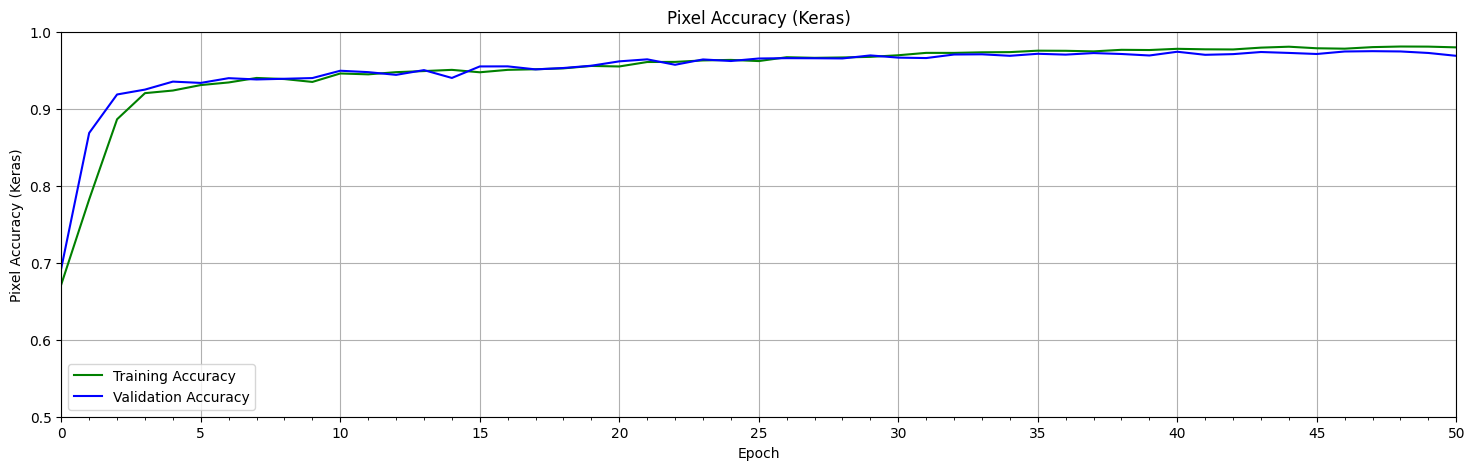

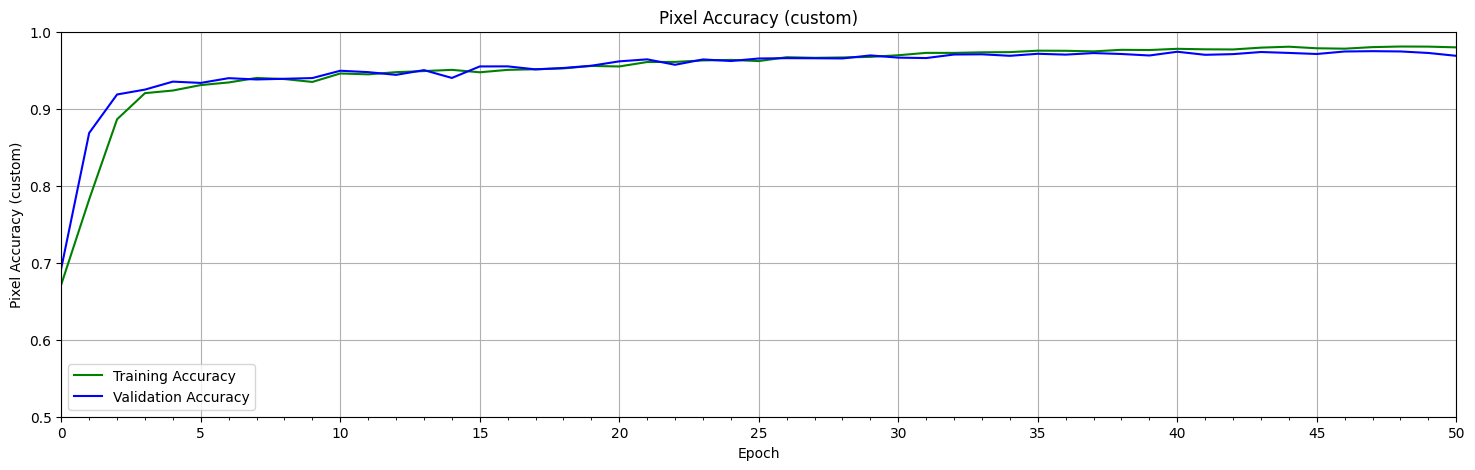

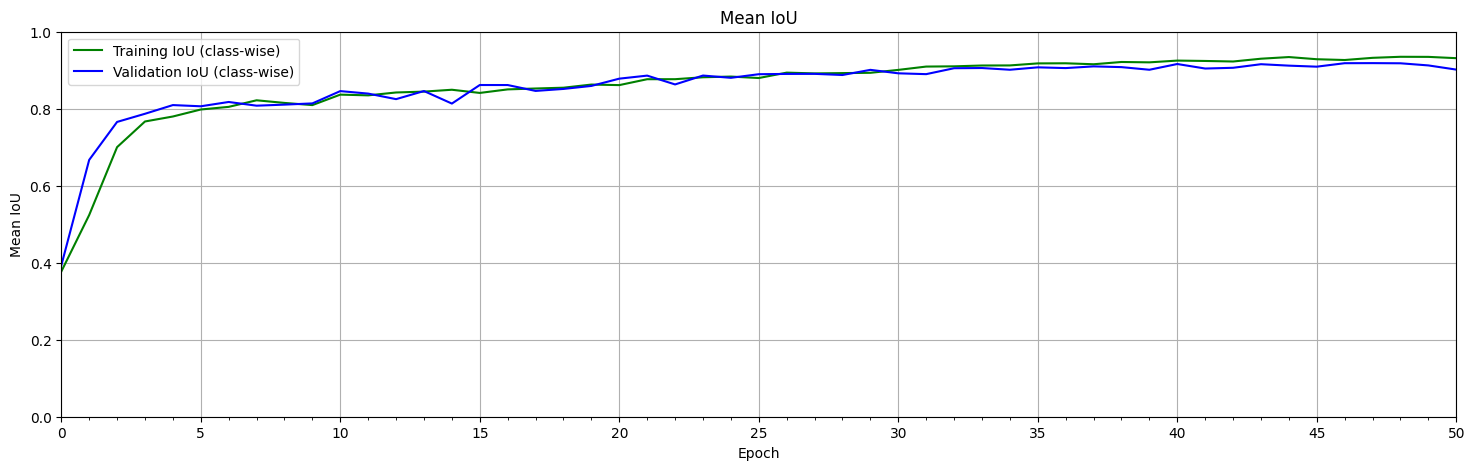

In [ ]:
# Pixel accuracy (Keras).
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Pixel accuracy (custom).
train_pxa = history.history["mean_pixel_accuracy"]
valid_pxa = history.history["val_mean_pixel_accuracy"]

# Mean IoU (class-wise).
train_iou  = history.history["mean_iou"]
valid_iou  = history.history["val_mean_iou"]

plot_results([ train_acc, valid_acc ],
            ylabel="Pixel Accuracy (Keras)",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_pxa, valid_pxa ],
            ylabel="Pixel Accuracy (custom)",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_iou, valid_iou ],
            ylabel="Mean IoU",
            ylim = [0.0, 1.0],
            metric_name=["Training IoU (class-wise)", "Validation IoU (class-wise)"],
            color=["g", "b"])

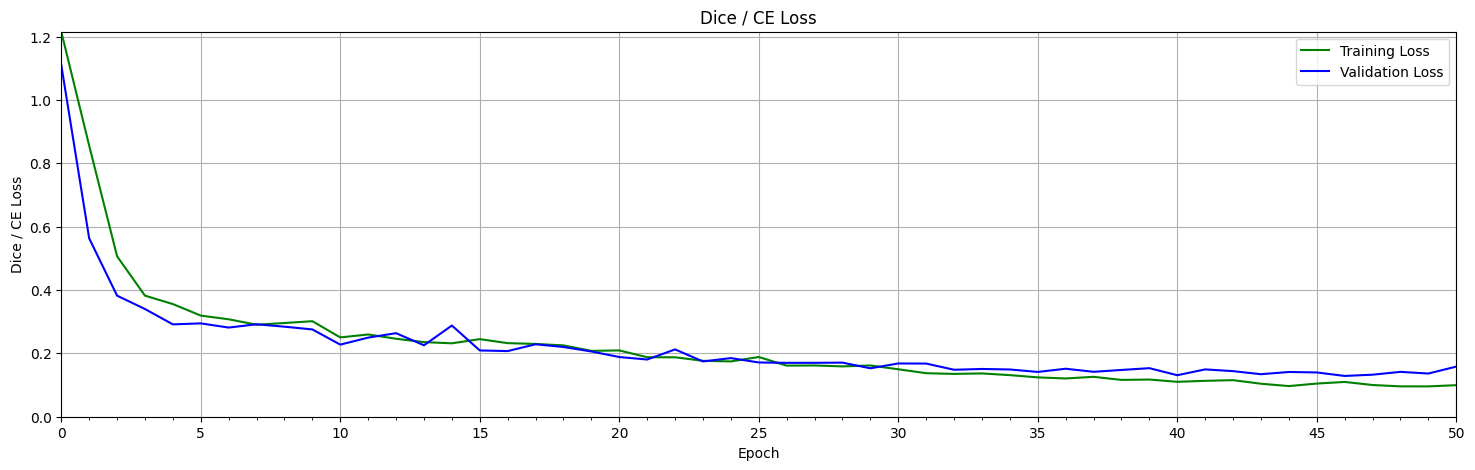

In [ ]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Dice / CE Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 12 Perform Inference

For inference, we will use the same validation data as we did during training. We will plot the ground truth images, the ground truth masks, and the predicted segmentation maps overlayed on the ground truth images.

### 12.1 Load the Trained Model

When loading the model, we need to specify the optional `custom_objects` dictionary, mapping names (strings) to custom classes or functions to be considered during deserialization.

In [ ]:
trained_model = tf.keras.models.load_model(version_dir,
                                           custom_objects={'mean_pixel_accuracy':mean_pixel_accuracy,
                                                           'mean_iou': mean_iou,
                                                           'dice_coef_loss':dice_coef_loss})

evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation pixel accuracy (Keras):  {evaluate[1]*100.:.3f}")
print(f"Model evaluation pixel accuracy (custom): {evaluate[2]*100.:.3f}")
print(f"Model evaluation mean IoU (class-wise):   {evaluate[3]*100.:.3f}")

5/5 [==============================] - 2s 202ms/step - loss: 0.1288 - accuracy: 0.9743 - mean_pixel_accuracy: 0.9743 - mean_iou: 0.9182
Model evaluation pixel accuracy (Keras):  97.433
Model evaluation pixel accuracy (custom): 97.433
Model evaluation mean IoU (class-wise):   91.823


### 12.2 Inference

In [ ]:
def inference(model, dataset):

    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, data in enumerate(dataset):

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype('float32')
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img).astype('uint8')
        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20,8))

            # Display the original image.
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text('Actual frame')
            plt.axis('off')

            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_title('Ground truth labels')
            ax2.imshow(true_mask)
            plt.axis('off')

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i]
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_title('Predicted labels')
            ax3.imshow(pred_mask)
            plt.axis('off')

            # Display the predicted segmentation mask overlayed on original image.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color_display)
            overlayed_image = image_overlay((batch_img[i]), np.array(pred_mask_rgb.astype('uint8')))
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_title('Overlayed image')
            ax4.imshow(overlayed_image)
            plt.axis('off')

            plt.show()

1/1 [==============================] - 0s 226ms/step


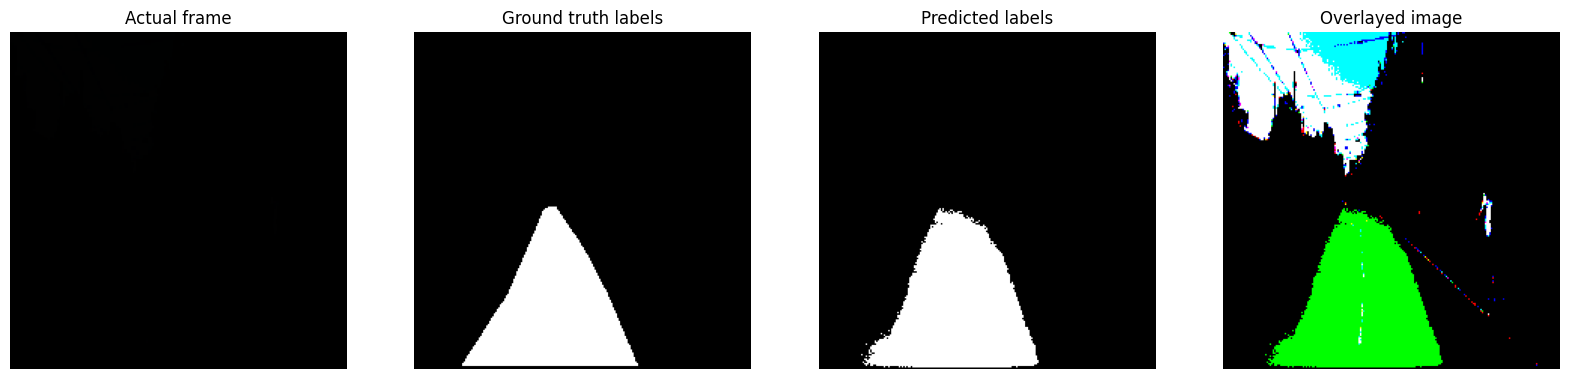

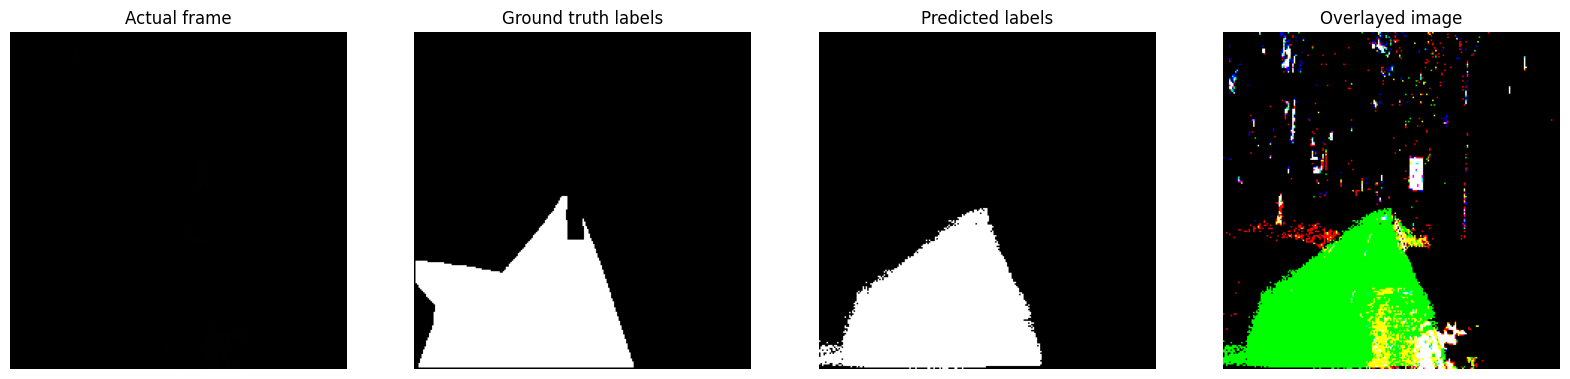

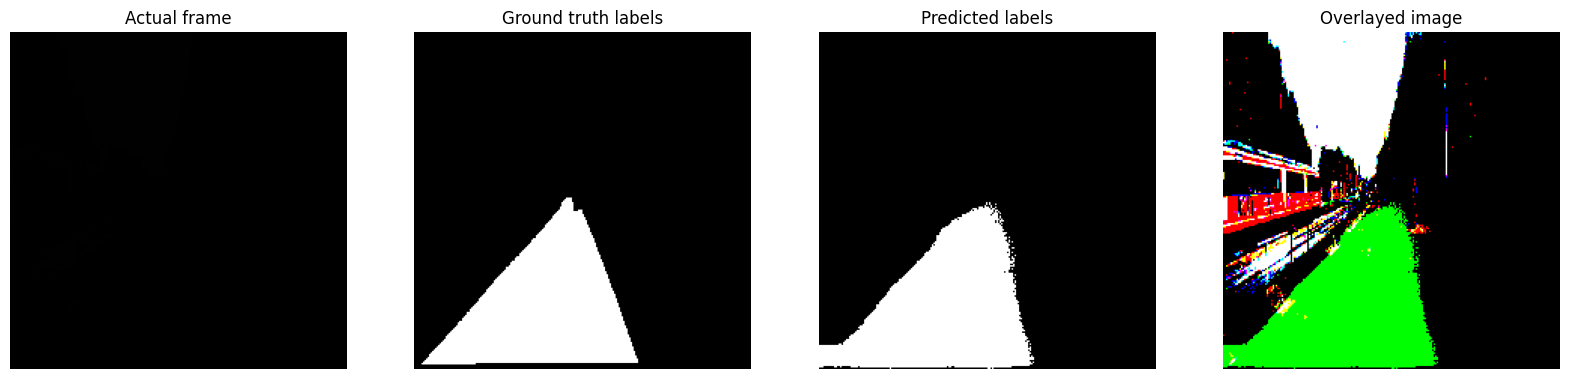

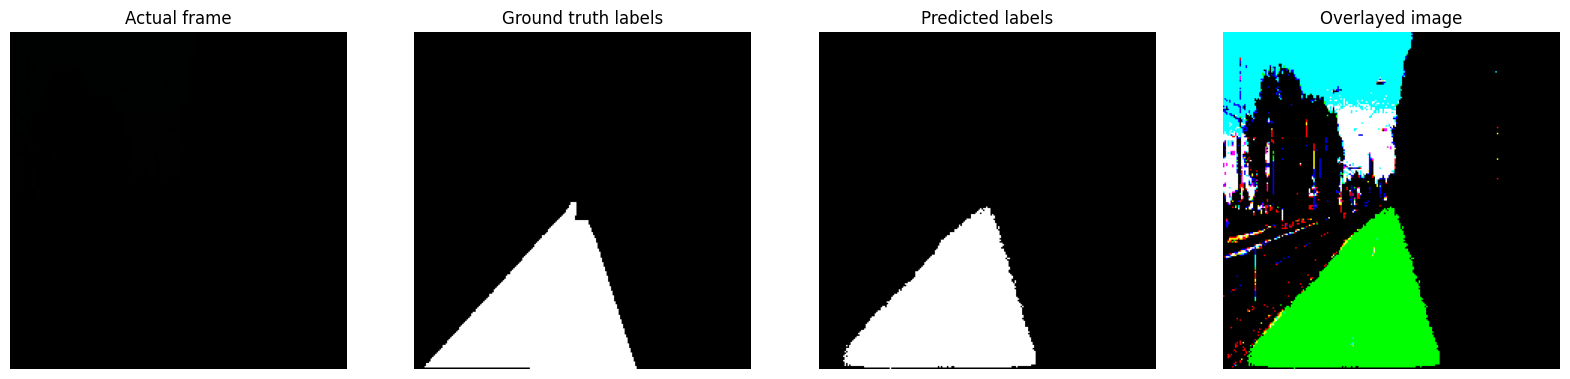

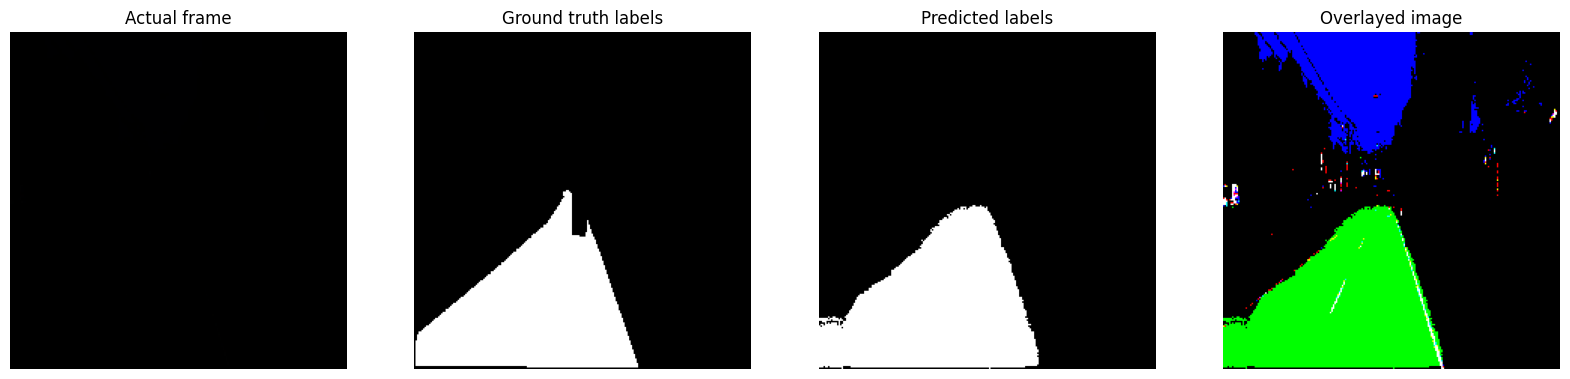

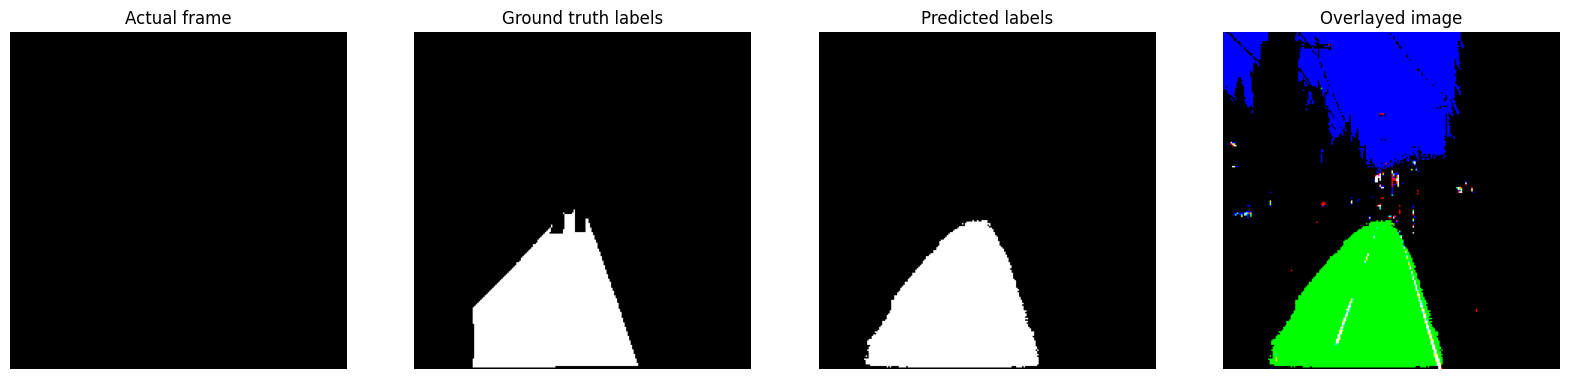

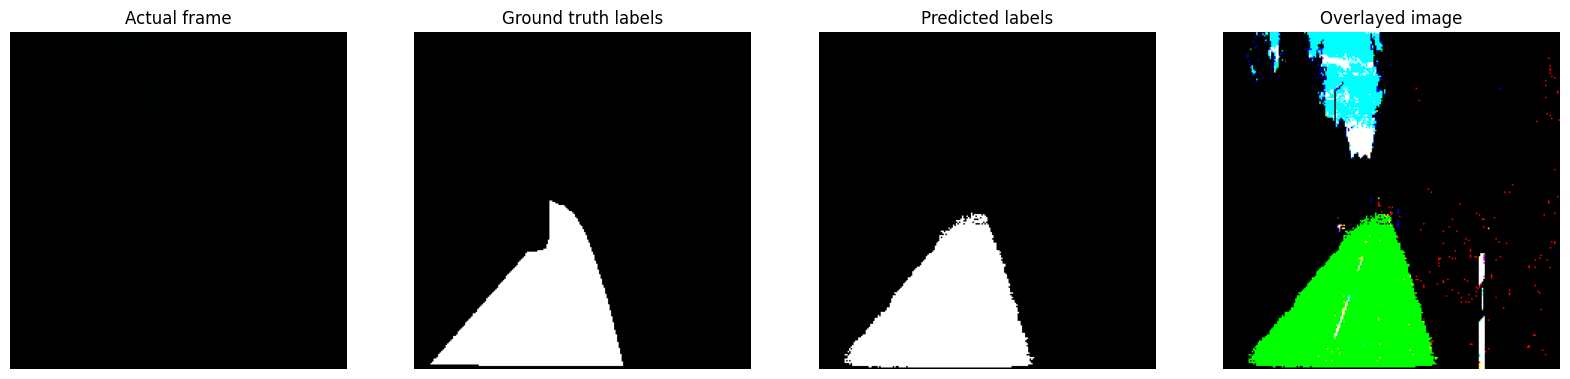

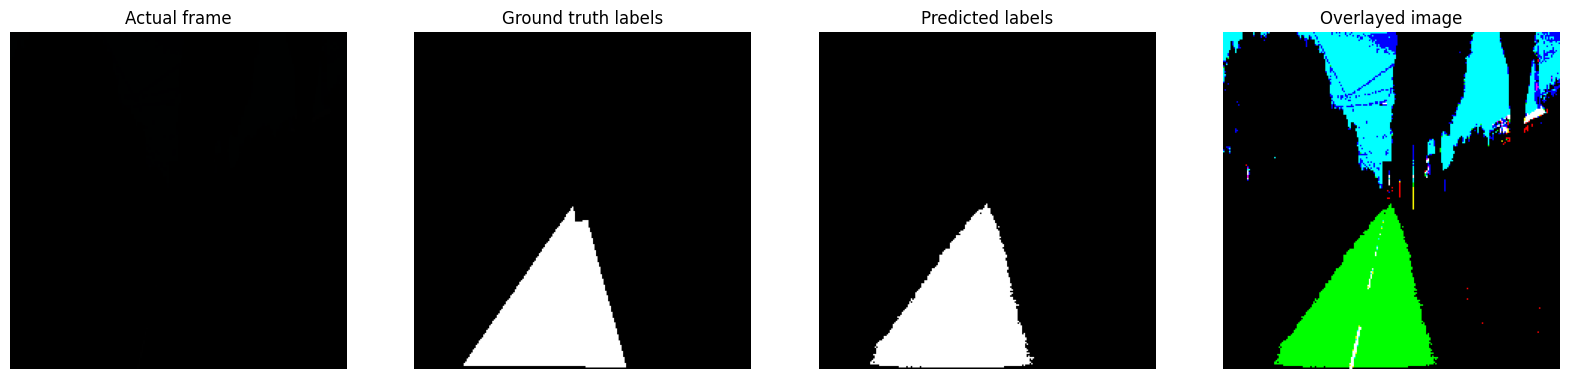

1/1 [==============================] - 0s 26ms/step


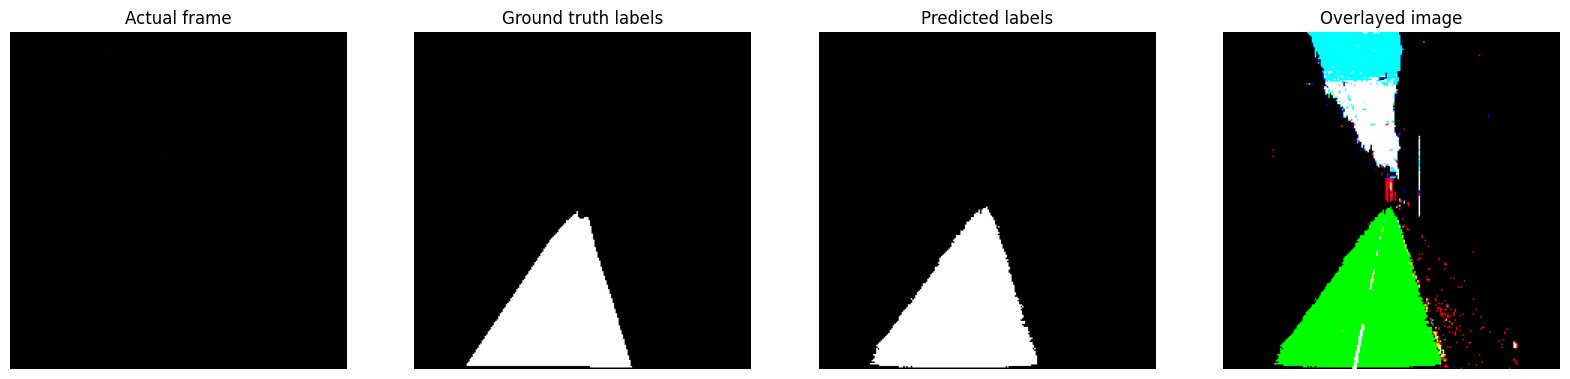

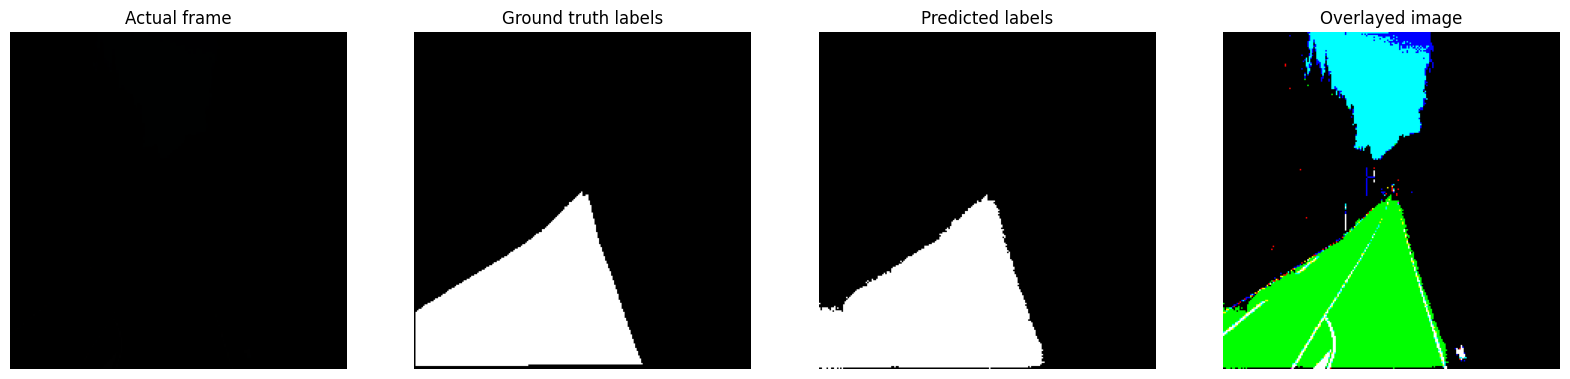

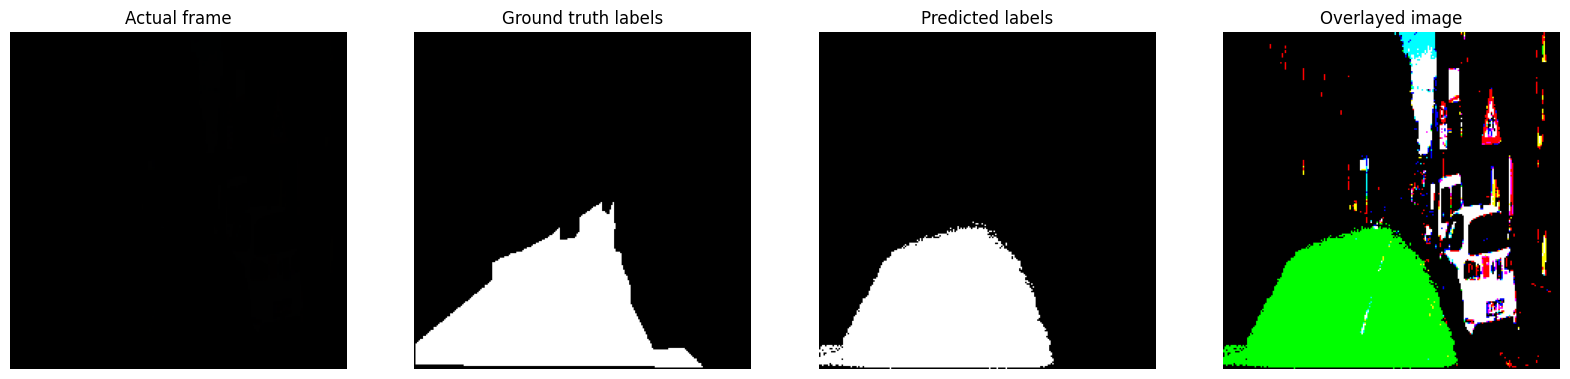

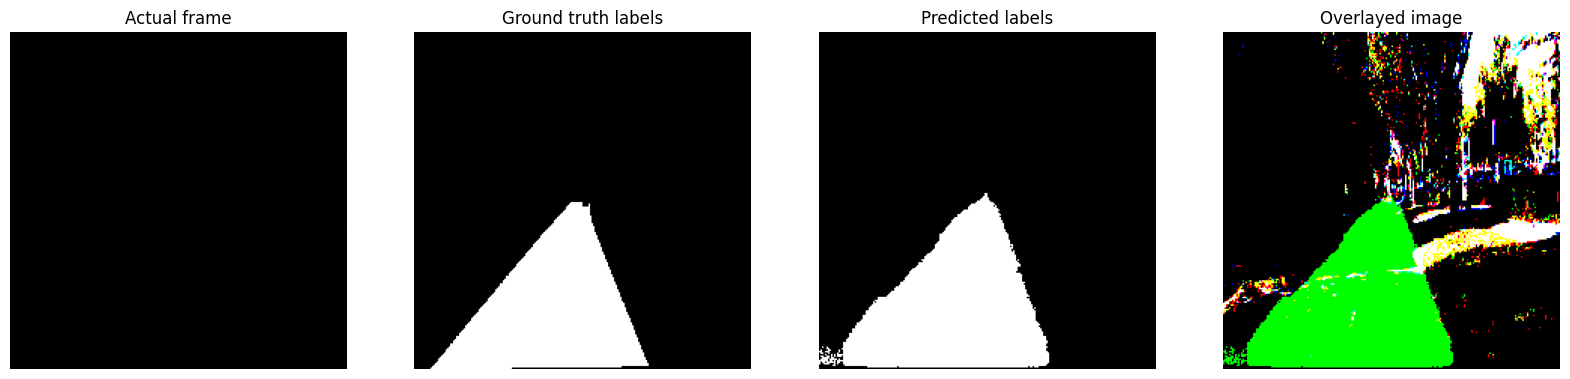

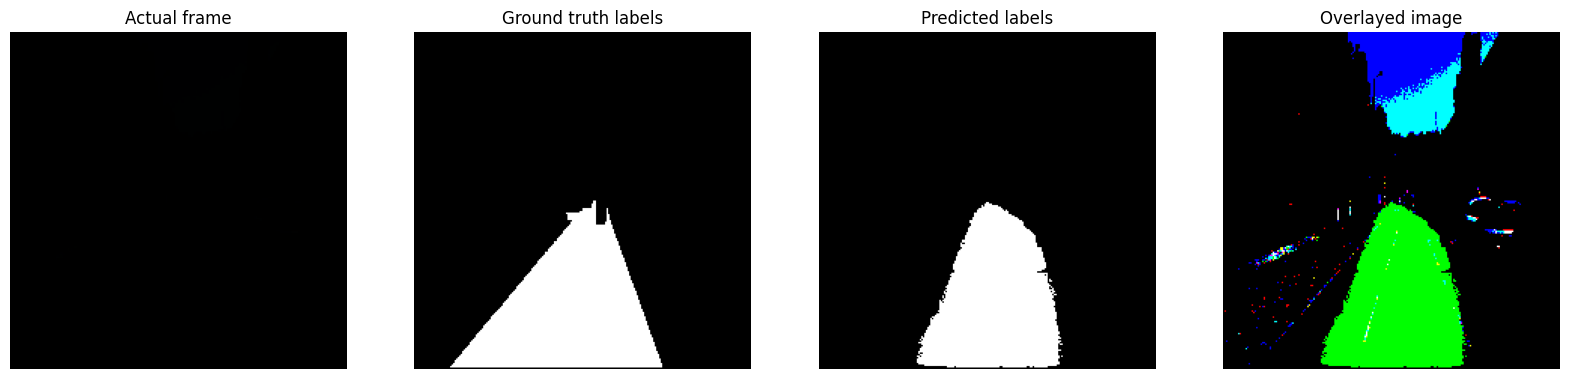

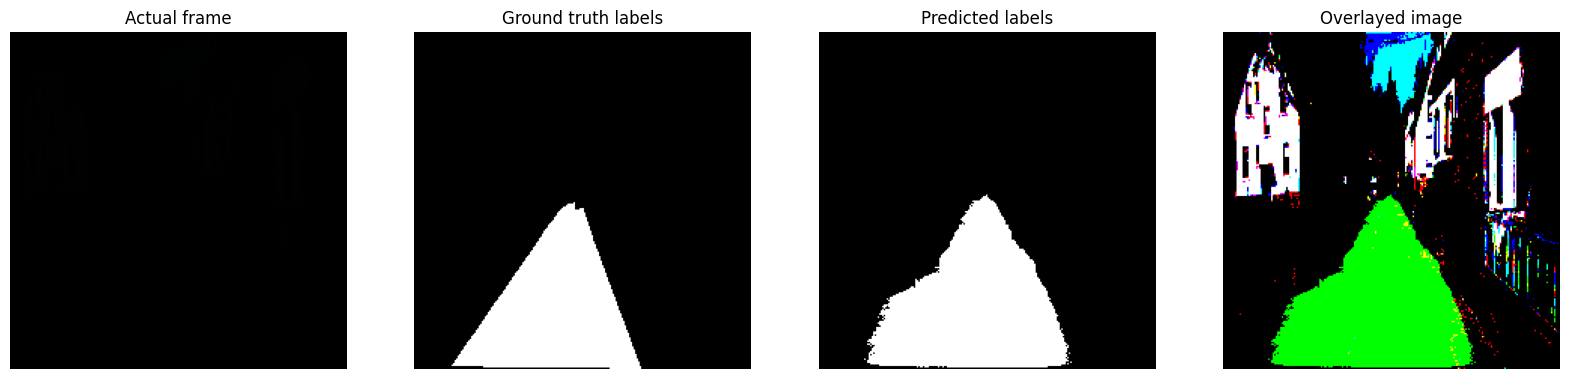

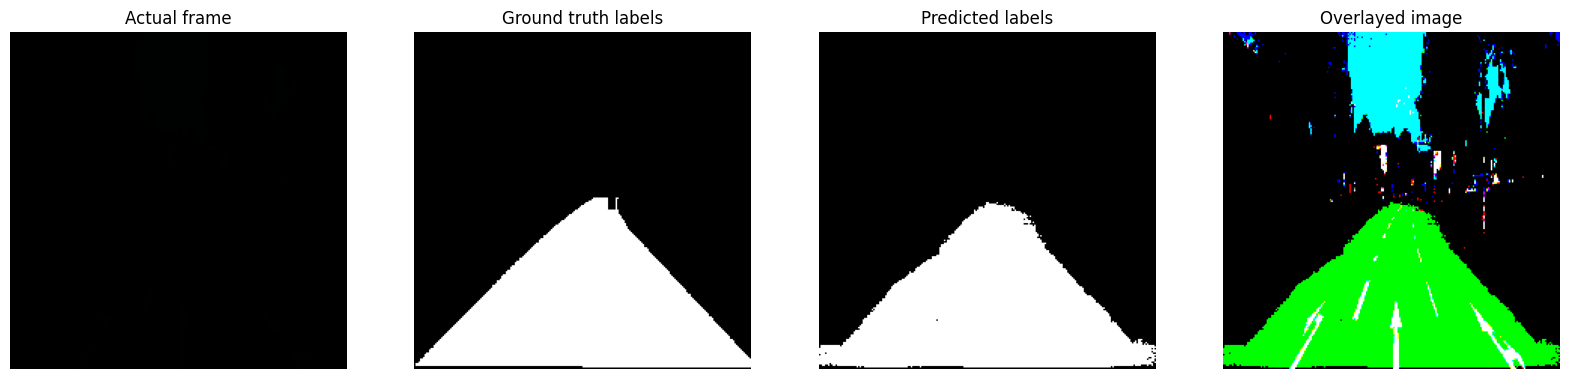

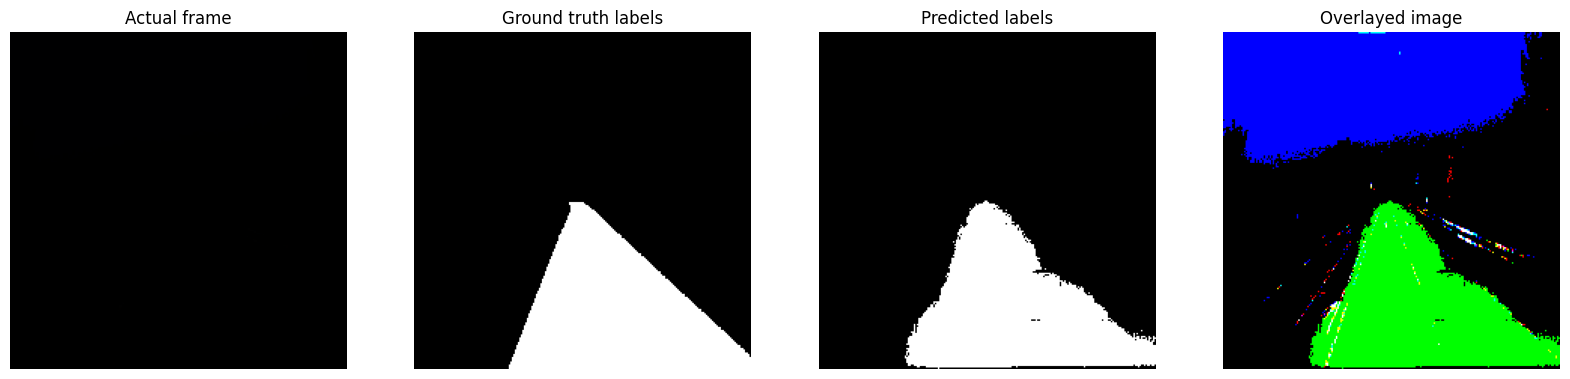

1/1 [==============================] - 0s 27ms/step


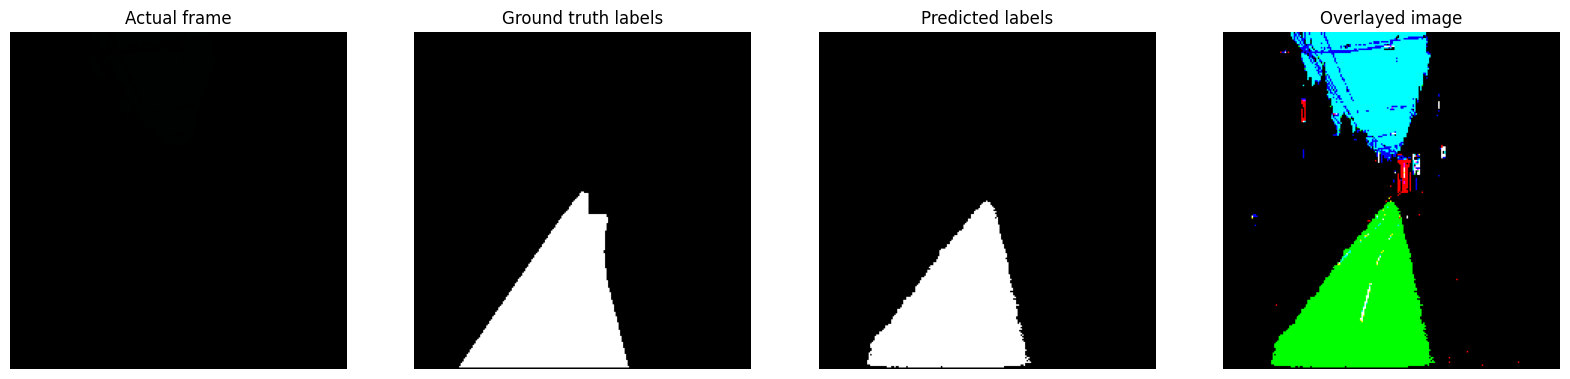

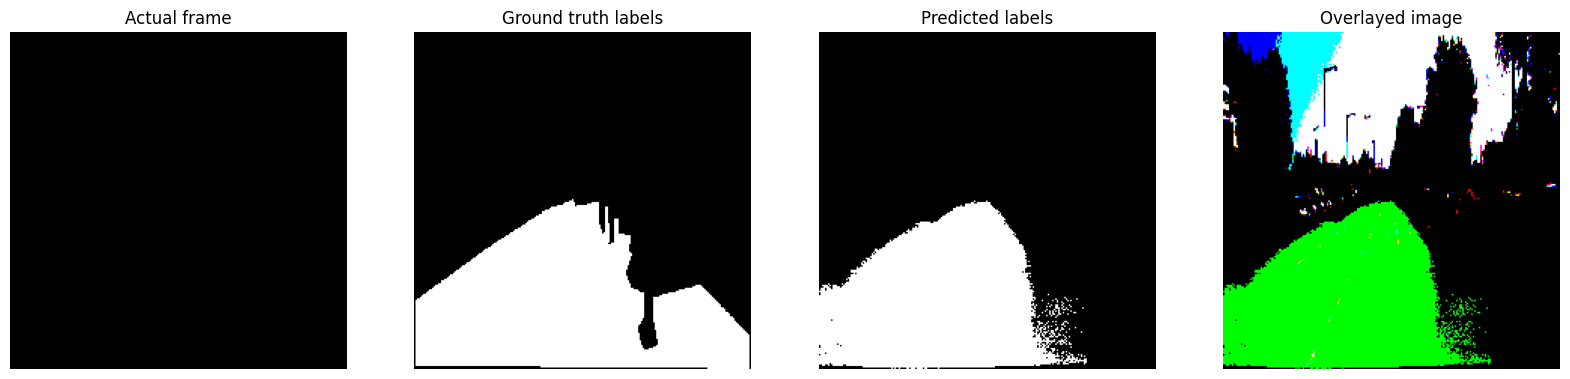

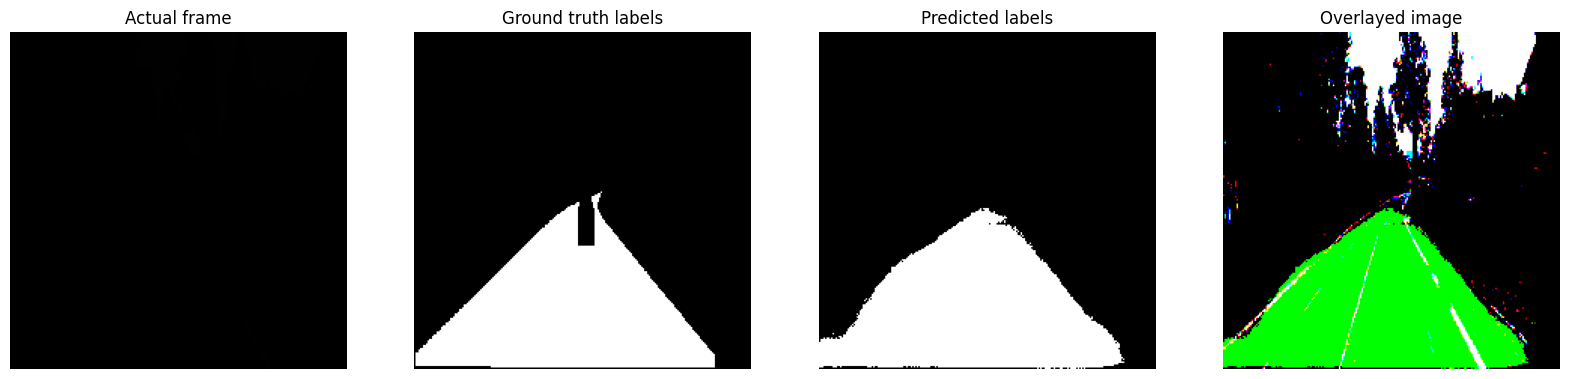

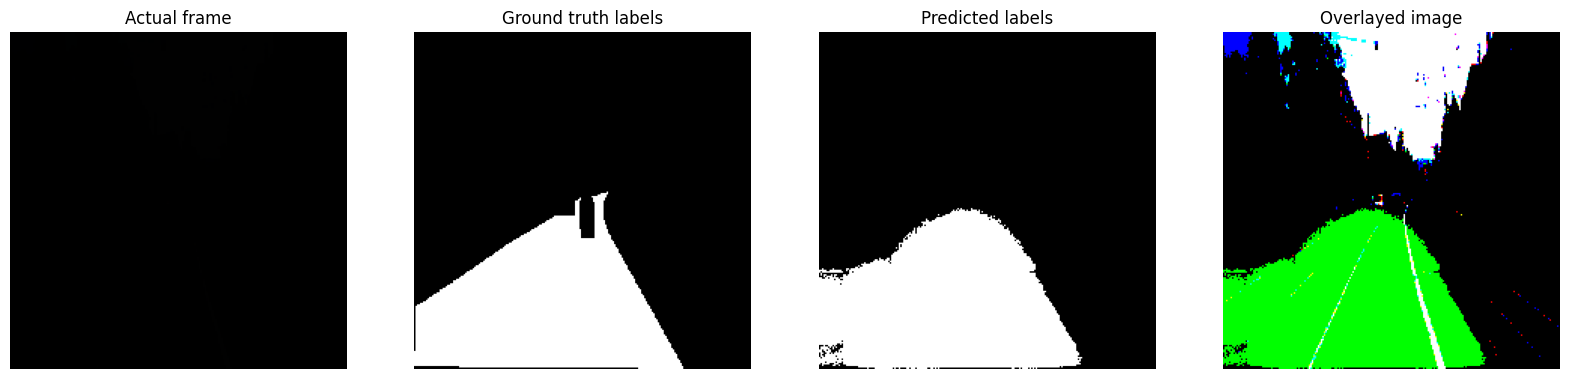

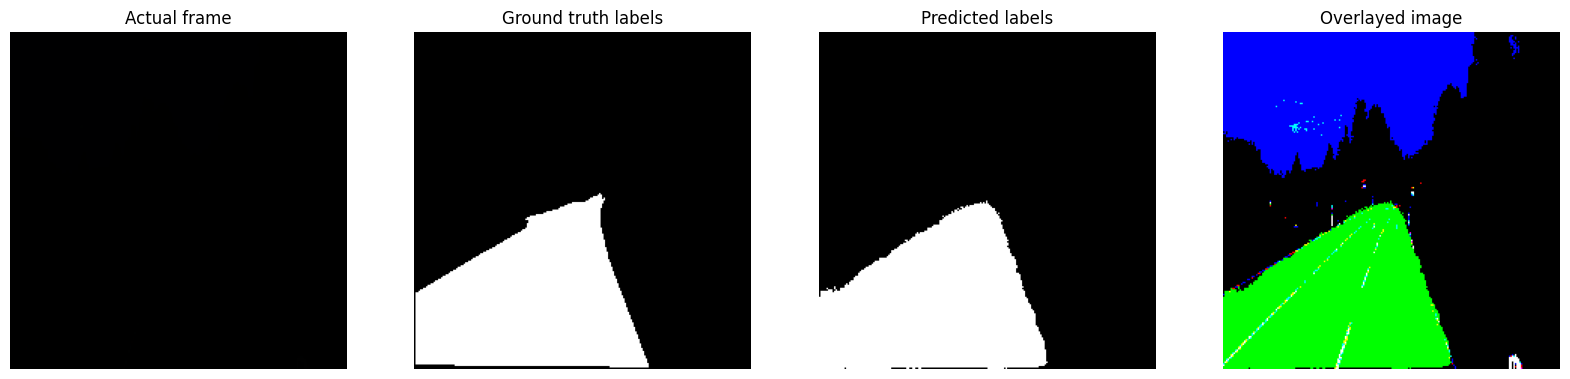

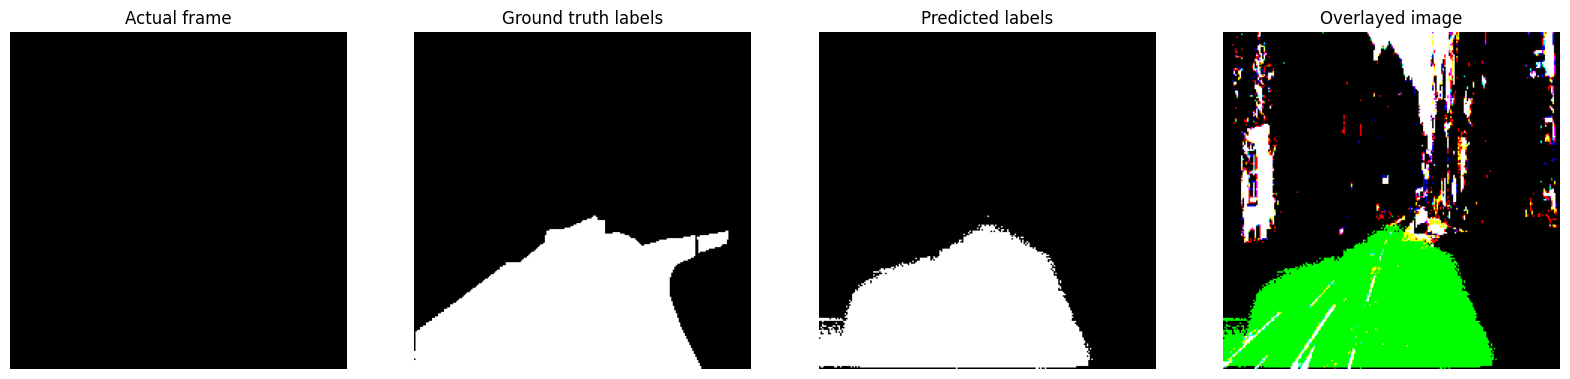

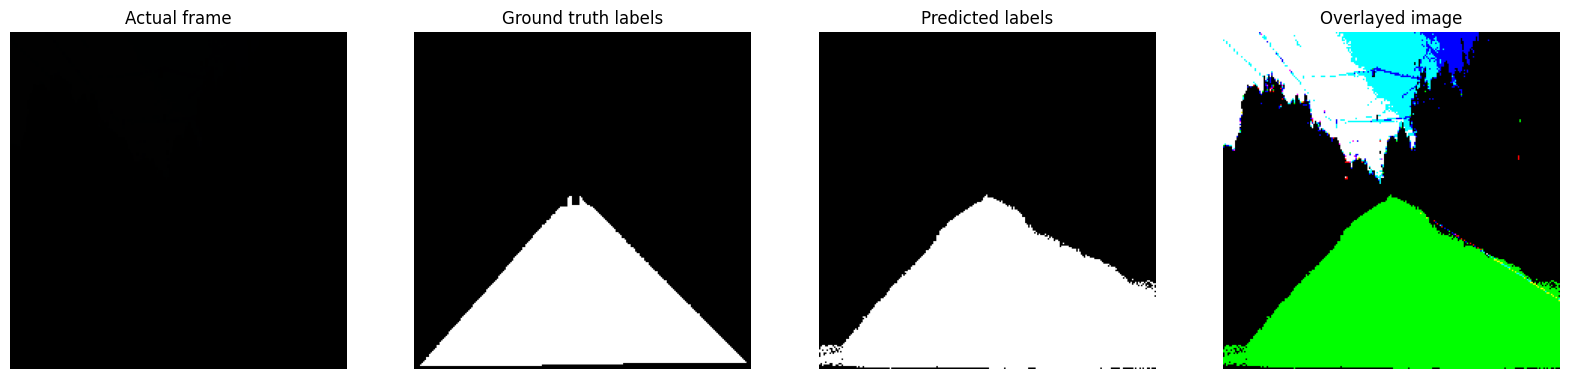

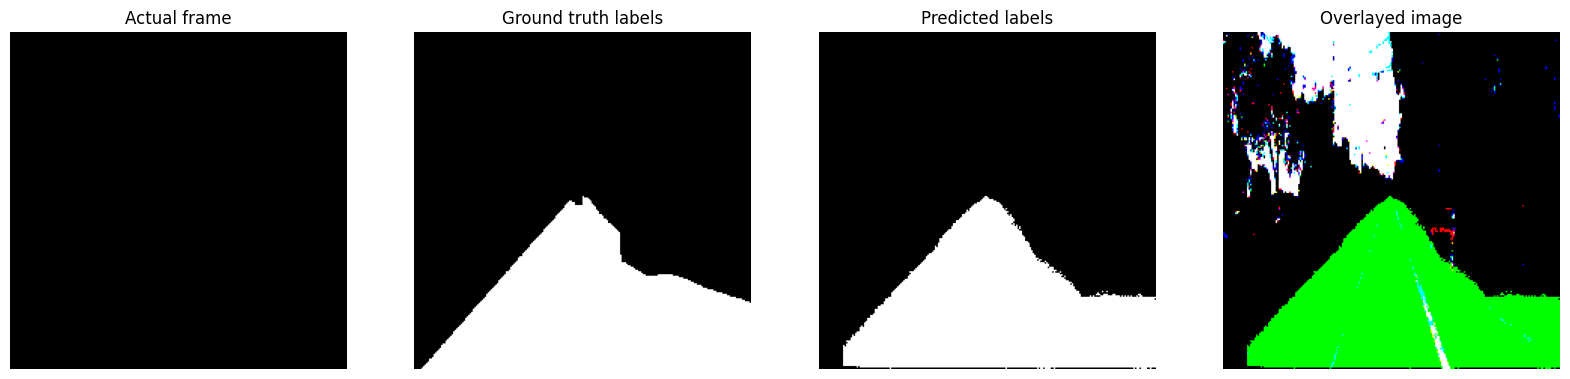

1/1 [==============================] - 0s 41ms/step


In [ ]:
inference(trained_model, valid_ds)

## 13 Conclusion

In this notebook, we demonstrated how to add **custom accuracy metrics** to the training processing pipeline so they can be automatically computed during training and plotted for evaluation. The process requires three basic steps:

1. Define a function that computes the metric
2. Add the function name to the list of desired metrics when compiling the model
3. Retrieve the computed metric from the training `history` object

We also showed how you can create and use a **custom loss function.** In future notebooks, we will make use of these custom functions.